<a href="https://colab.research.google.com/github/nrajmalwar/Project/blob/master/Session%206/Assignment_6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Dataset

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, Conv2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

Plot random images from each class

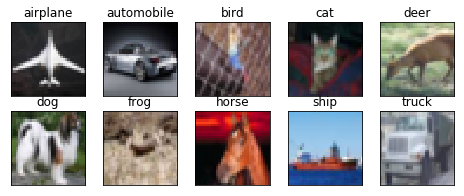

In [24]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Model Architecture



Build a model 5 different types of Convolutions

In [31]:
# Define the new model with Functional API

input = Input(shape=(None, None, 3))

# Block 1

# Normal Convolution
layer1 = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input) # RF = 3 ; output_size = 32
layer1 = BatchNormalization(name='norm_1')(layer1)
layer1 = Activation("relu")(layer1)

# Separable Convolution

#First convolve with 32 kernels of size 3x1
layer2 = Conv2D(32, (3,1), strides=(1,1), padding='same', name='conv_2_1', use_bias=False)(layer1) 
#Next, convolve with 64 kernels of size 1x3
layer2 = Conv2D(64, (1,3), strides=(1,1), padding='same', name='conv_2_2', use_bias=False)(layer2) # 5
layer2 = BatchNormalization(name='norm_2')(layer2)
layer2 = Activation("relu")(layer2)

# Depthwise Separable Convolution
layer3 = SeparableConv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(layer2) # 7
layer3 = BatchNormalization(name='norm_3')(layer3)
layer3 = Activation("relu")(layer3)

# Dropout layer
layer3 = Dropout(0.25)(layer3)

# 1x1 Convolution
layer4 = Conv2D(32, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(layer3) # 7
layer4 = BatchNormalization(name='norm_4')(layer4)
layer4 = Activation("relu")(layer4)

layerm1 = MaxPooling2D(pool_size=(2, 2))(layer4) # 14 ; 16

# Grouped Convolution with 3x3 and 5x5

# First layer with 3x3 convolution
layer5_1 = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_5_1', use_bias=False)(layer4) # 16
layer5_1 = BatchNormalization(name='norm_5_1')(layer5_1)
layer5_1 = Activation("relu")(layer5_1)

# Second layer with 5x5 convolution
layer5_2 = Conv2D(64, (5,5), strides=(1,1), padding='same', name='conv_5_2', use_bias=False)(layer5_1) # 18
layer5_2 = BatchNormalization(name='norm_5_2')(layer5_2)
layer5_2 = Activation("relu")(layer5_2)

# Concatenate the above two layers
layer6 = Concatenate(axis=-1)([layer5_1, layer5_2])

# Grouped Convolution with 3x3, dilation=1 and dilation=2

# First layer with 3x3 convolution with dilation=1 (normal convolution)
layer7_1 = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_7_1', use_bias=False)(layer6) # 20
layer7_1 = BatchNormalization(name='norm_7_1')(layer7_1)
layer7_1 = Activation("relu")(layer7_1)

# Second layer with 3x3 convolution with dilation=2
layer7_2 = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_7_2', use_bias=False, dilation_rate=2)(layer7_1) # 20
layer7_2 = BatchNormalization(name='norm_7_2')(layer7_2)
layer7_2 = Activation("relu")(layer7_2)

# Concatenate the above two layers
layer8 = Concatenate(axis=-1)([layer7_1, layer7_2])

# Dropout layer
layer8 = Dropout(0.25)(layer8)

# 1x1 Convolution
layer8 = Conv2D(32, (1,1), strides=(1,1), padding='same', name='conv_8', use_bias=False)(layer8) # 20
layer8 = BatchNormalization(name='norm_8')(layer8)
layer8 = Activation("relu")(layer8)

layerm2 = MaxPooling2D(pool_size=(2, 2))(layer8) # 40 ; 8

layer9 = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(layer8) # 42
layer9 = BatchNormalization(name='norm_9')(layer9)
layer9 = Activation("relu")(layer9)

layer10 = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_10', use_bias=False)(layer9) # 44
layer10 = BatchNormalization(name='norm_10')(layer10)

layer11 = Conv2D(10,(1,1), strides=(1,1), padding='same', name='conv_11', use_bias=False)(layer10) # 44

layer12 = GlobalAveragePooling2D(data_format=None)(layer11)
layer12 = Activation('softmax')(layer12)

output = layer12

model = Model(inputs=[input], outputs=[output])
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, None, None, 3 864         input_11[0][0]                   
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, None, None, 3 128         conv_1[0][0]                     
__________________________________________________________________________________________________
activation_88 (Activation)      (None, None, None, 3 0           norm_1[0][0]                

In [0]:
# LRScheduler

def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

# Use Adam optimizer with a starting value of 0.003
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 69s 178ms/step - loss: 1.3744 - acc: 0.4960 - val_loss: 2.4719 - val_acc: 0.3997
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
390/390 [==============================] - 66s 168ms/step - loss: 0.9565 - acc: 0.6585 - val_loss: 1.5555 - val_acc: 0.5219
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
390/390 [==============================] - 66s 168ms/step - loss: 0.7840 - acc: 0.7226 - val_loss: 2.3016 - val_acc: 0.4322
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
390/390 [==============================] - 66s 168ms/step - loss: 0.6644 - acc: 0.7655 - val_loss: 1.2358 - val_acc: 0.6058
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
390/390 [==============================] - 66s 168ms/step - loss: 0.5743 - acc: 0

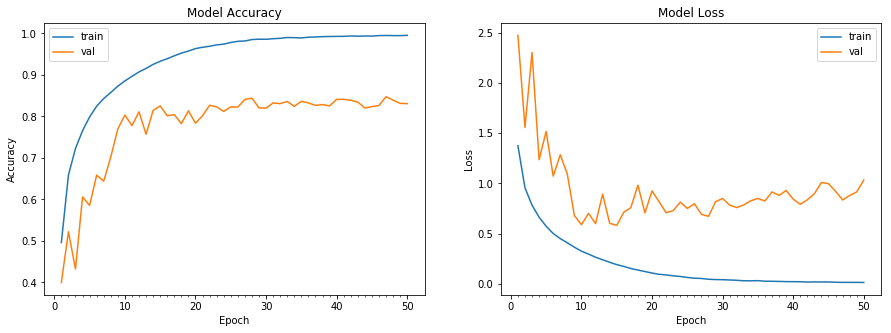

Accuracy on test data is: 83.08


In [33]:
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model for 50 epochs
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks=[LearningRateScheduler(scheduler, verbose=1)])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

1. We have saturated the training accuracy at around 99% and the validation accuracy at around 84%.
2. We used a total of 543,776 number of parameters.